<a href="https://colab.research.google.com/github/harshans164/Generative-AI/blob/main/Traffic_sign_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gtsrb-german-traffic-sign:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F82373%2F191501%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240620%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240620T103030Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D67f1434ca19ed29721c59898d841fab9aa0af3919d4b330bbdbe5c7957058d2a1e7a9ed17c28a4d855244b8da7f6bd2dbf0f018919c8acc2bfa5e9e077076dcbd991e0b09fa66d0bf525b445cc764dc94d649d66cac7b1b093cf28c7a5934c62c6e980c5799def3686c633b0ad01a78cc031ad57de023711f444df1f6e4bf6efff1d4b1ade942245b085c76620c94e1d4bc51ede21d3f24f3f45dc843ee374d7ffa489824550a8e36a082cc119b0788739c186dc380ec0749d666defec5795e06a23fb64216999fddb72bf7d958ca8b4db15dbe995005d9de7323af2e1632b0dcf254033fdcab11ce6c44dadc11d2db9e28bff7a35c5de539663cf12e80e04bf,sample-video:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5239571%2F8729614%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240620%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240620T103030Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3f7f656c16e5f8563af6886dc6ceb96931077c56a91d48621958da209bf1d409ba9808b883a111dd0debce064902f75c0758b90d374d56e7e720d52f2bba94899209379d16513ad48a1cec073723f14f8be5d81df9223eef9f81e8988eea9e0b2177ccfe79856104dd2d168fc2c33443a314d623c5e01be110661e0b13f0351d425f0b96914118d53329e8ac474a88fca2975b1eab5f8bb2baa8771364b5133ca86a3633fc432fb6817d51c38686862520ec11d0bbf1c63285ef3989ce750cbedafb68afa5c9302370dbad5da549d32cdcc4b52fc83a5a3a44fe131a937e3ba8cbba522e257045087531b4e96943a94e32fddb134aaf49bbd656e9f227b0b0ce'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 641568792 bytes downloaded
Downloaded and uncompressed: gtsrb-german-traffic-sign
[==================================================] 2917892 bytes downloaded
Downloaded and uncompressed: sample-video
Data source import complete.


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU
from sklearn.utils import class_weight
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.losses import CategoricalCrossentropy
from keras.losses import MeanSquaredError

# Installing and importing imutils for prediction
# import imutils

#Data augmentation
import albumentations as A
import cv2


# Commonly used modules
import statistics
import pathlib
import random
import itertools

# Images, plots, display, and visualization
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import csv
from PIL import Image
# from google.colab.patches import cv2_imshow
import pandas as pd
from matplotlib.patches import Rectangle

import os

from tqdm import tqdm

In [ ]:
from keras import backend as K

def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]

    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)

    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection

    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return tf.reduce_mean(iou, axis=-1)

    #return iou

def IoU(y_true, y_pred):

    iou = tf.numpy_function(iou_metric, [y_true, y_pred], tf.float32)

    return iou

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of 80km/h speed limit',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No overtaking',
            10:'No overtaking for heavy vehicles',
            11:'Intersection with priority',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No entry',
            16:'No heavy vehicles',
            17:'Wrong way',
            18:'Danger',
            19:'Dangerous curve to the left',
            20:'Dangerous curve to the right',
            21:'Double curve',
            22:'Bumps',
            23:'Slippery road',
            24:'Narrow road on the right',
            25:'Roadworks',
            26:'Traffic light',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycle crossing',
            30:'Snow/Ice danger',
            31:'Animal crossing',
            32:'End of speed and overtaking limits',
            33:'Turn right',
            34:'Turn left',
            35:'Straight ahead only',
            36:'Straight ahead or right',
            37:'Straight ahead or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout',
            41:'End of no overtaking',
            42:'End of no overtaking for heavy vehicles' }

In [ ]:
# Mounting images directories
BASE_IN = "/kaggle/input/gtsrb-german-traffic-sign"
TRAIN_DIR = os.path.sep.join([BASE_IN, "Train"])
TEST_DIR = os.path.sep.join([BASE_IN, "Test"])
ANNOTATION_TRAIN = os.path.sep.join([BASE_IN, "Train.csv"])
ANNOTATION_TEST = os.path.sep.join([BASE_IN, "Test.csv"])

#Mounting output directories
BASE_DRIVE = "/kaggle/working"
BASE_OUT = os.path.sep.join([BASE_DRIVE, "Output"])
MODEL_PATH = os.path.sep.join([BASE_OUT, "model.h5"])
LB_PATH = os.path.sep.join([BASE_OUT, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUT, "plots"])

# Fixed variables
WIDTH = 128
HEIGHT = 128
N_CLASSES = 43

#Deep learning hyperparameters
BATCH_SIZE = 16
N_CHANNELS = 3
INIT_LR = 3e-4
NUM_EPOCHS = 20

In [ ]:
params = {'dim': (WIDTH,HEIGHT),
          'batch_size': BATCH_SIZE,
          'n_classes': N_CLASSES}

#Initialize list of class labels, bounding box coordinates, image paths
print("Loading lists...")
labels = []
bboxes = []
imagePaths = []

#Load annotation file
with open(ANNOTATION_TRAIN, "r") as csvfile:
    rows = csv.reader(csvfile)
    next(rows)
    #Loop rows
    for row in tqdm(rows):
        #Obtain each data from the csv
        (w, h, startX, startY, endX, endY, label, relativeFilePath) = row

        #Reading complete filepaths
        imagePath = os.path.sep.join([BASE_IN, relativeFilePath])

        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / float(w)
        startY = float(startY) / float(h)
        endX = float(endX) / float(w)
        endY = float(endY) / float(h)

        # update our list of class labels, bounding boxes, and
        # image paths
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
#Defining label binarizer for one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

Loading lists...


39209it [00:00, 296917.28it/s]


In [ ]:
len(imagePaths)

In [ ]:

#Putting all labels' indices in a list
list_all_IDs = list(range(0, len(labels)))
print(len(list_all_IDs))
#Generating ids of training and validation set, keeping same data distribution based on labels
list_train_IDs, list_val_IDs  = train_test_split(list_all_IDs, test_size=0.3,
                                                 stratify=labels
                                                 )

39209


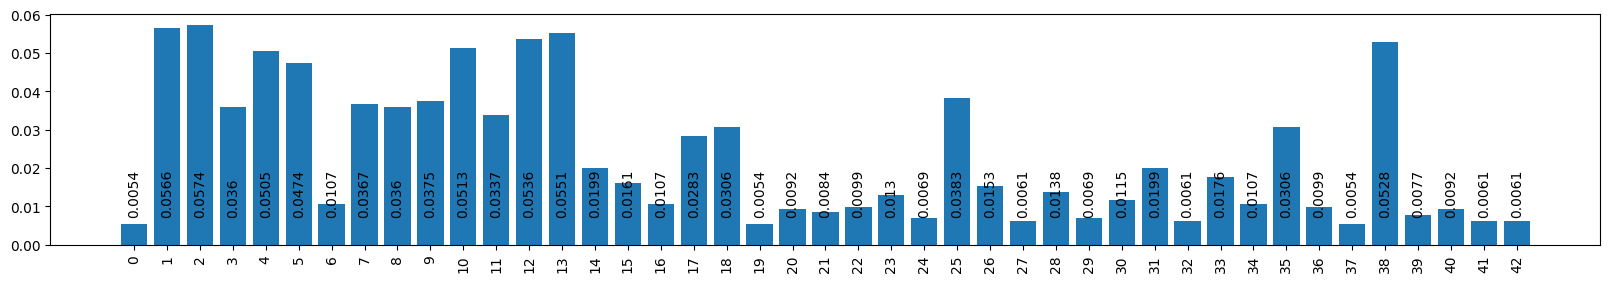

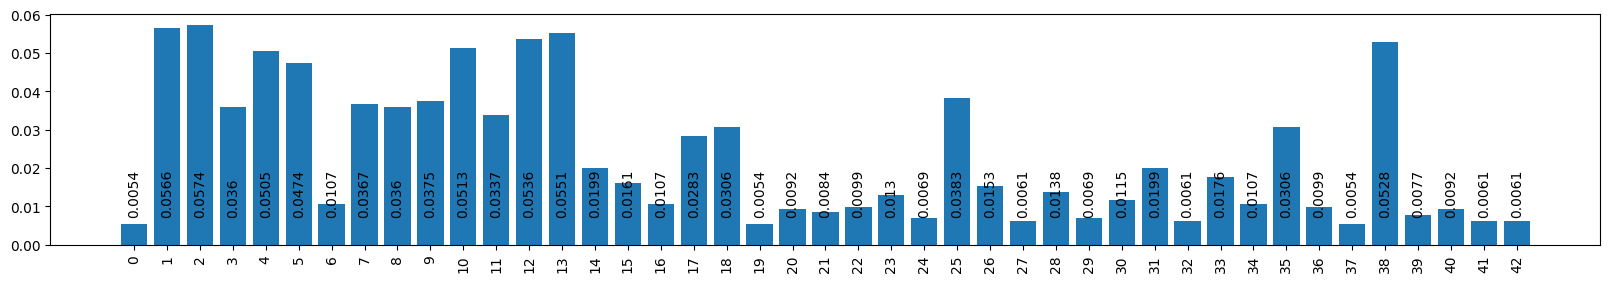

In [ ]:
def get_class_counts(df):
  unique, counts = np.unique(df, return_counts=True)
  return dict(zip(unique, counts))

def get_class_proportions(df):
  class_counts = get_class_counts(df)
  dictionary = {val[0]: round(val[1]/len(df), 4) for val in class_counts.items()}
  return dictionary

def plot_distribution(prop):
  int_dict = {int(k) : v for k, v in prop.items()}
  sorted_dict = dict(sorted(int_dict.items()))

  names = list(sorted_dict.keys())
  values = list(sorted_dict.values())

  plt.figure(figsize=(20, 3))
  plt.bar(range(len(sorted_dict)), values, tick_label=names)
  plt.xticks(range(len(sorted_dict)), names, rotation='vertical')

  ax = plt.gca()
  for bar, v in zip(ax.patches, values):
    plt.text(y=0.008, x=bar.get_x()+bar.get_width()/2, s=str(v), horizontalalignment="center", rotation='vertical')
  plt.show()

#Getting distributions
propTrain = get_class_proportions(lb.classes_[np.argmax(labels[list_train_IDs], axis=1)])
propVal = get_class_proportions(lb.classes_[np.argmax(labels[list_val_IDs], axis=1)])

#Plotting distributions
plot_distribution(propTrain)
plot_distribution(propVal)

In [ ]:
y_integers = np.argmax(labels[list_train_IDs], axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers)

train_class_weights = dict(enumerate(class_weights))

#Because we have two outputs
train_correct_class_weights=[None, train_class_weights]

In [ ]:
#defining a complex augmentation pipeline
transform = A.Compose([
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.3)
    ],
    bbox_params=A.BboxParams(format='albumentations', min_visibility=0.1, label_fields=[]),
)

def augment(images, bboxes):
  augImages=[]
  augBBoxes=[]
  for i in range(len(images)):
    transformed = transform(image=cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB), bboxes=[bboxes[i]])
    augImages.append(cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR))
    augBBoxes.append(transformed['bboxes'][0])
  return (augImages, augBBoxes)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, bboxes, labels, imagePaths, batch_size, dim,
                 n_classes, class_weights=None, augmentation=False, shuffle=False):
        'Initialization'
        self.shuffle = shuffle
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.imagePaths = imagePaths
        self.bboxes = bboxes
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.class_weights = class_weights
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        #checking if class_weights are specified
        if self.class_weights is None:
          # Generate data
          X, y_label, y_bounding_box = self.__data_generation(list_IDs_temp)

          return X, {"class_label": y_label, "bounding_box":y_bounding_box}

        else:
          # Generate data
          X, y_label, y_bounding_box, sample_weight = self.__data_generation(list_IDs_temp)

          return X, {"class_label": y_label, "bounding_box":y_bounding_box}, sample_weight

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

        X = []
        y_label=[]
        y_bounding_box=[]

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
        #for i in list_IDs_temp:
            # Store images for batch
            image = load_img(self.imagePaths[ID], target_size=(self.dim))
            image = img_to_array(image)
            X.append(image)

            # Store labels and bounding boxes for batch
            y_label.append(self.labels[ID])
            y_bounding_box.append(self.bboxes[ID])

        # convert the data, class labels, bounding boxes to NumPy arrays, scaling the input pixel from the range [0, 255] to [0, 1]
        X = np.array(X, dtype = "float32") / 255
        y_label = np.array(y_label)
        y_bounding_box = np.array(y_bounding_box, dtype="float32")

        #checking if there is augmentation flag and performing it
        if self.augmentation:
          (X, y_bounding_box) = augment(X, y_bounding_box)
          X = np.asarray(X)
          y_bounding_box = np.asarray(y_bounding_box)

        #checking if class_weights are specified, if they are, you provide sample weights too
        if self.class_weights is None:
          return X, y_label, y_bounding_box

        else:
          z = compute_sample_weight(train_class_weights, np.argmax(labels[list_IDs_temp], axis=1))
          return X, y_label, y_bounding_box, z

In [ ]:
training_generator = DataGenerator(list_train_IDs, bboxes, labels, imagePaths, **params,
                                   augmentation=True,
                                   #class_weights=train_correct_class_weights,
                                   shuffle=True)

validation_generator = DataGenerator(list_val_IDs, bboxes, labels, imagePaths, **params, shuffle=False)

In [ ]:
print(len(list_train_IDs))

27446


In [ ]:
c=0
for i in training_generator:
    print(len(i[0][0]))
    c+=1
    if c==1:
        break

In [ ]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, Input
from keras.models import Model, Sequential


# Define the input tensor
input_tensor = Input(shape=(HEIGHT, WIDTH, 3))

# Create a Sequential model for the convolutional base
cnnBase = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(HEIGHT, WIDTH, 3)),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(2),
    Conv2D(128, 3, activation='relu'),
    Dropout(0.25),
    MaxPool2D(2),
    Conv2D(512, 3, activation='relu'),
    Dropout(0.5),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(2),
    Dropout(0.5),
    Flatten()
])

# Call the Sequential model on the input tensor to get the output
cnnOutput = cnnBase(input_tensor)

# Bounding box head
bboxHead = Dense(128, activation="relu")(cnnOutput)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# Class label head
softmaxHead = Dense(128, activation="relu")(cnnOutput)
softmaxHead = Dense(32, activation="relu")(softmaxHead)
softmaxHead = Dense(N_CLASSES, activation="softmax", name="class_label")(softmaxHead)

# Create the model
model = Model(
    inputs=input_tensor,
    outputs=[bboxHead, softmaxHead])

# Compile the model
model.compile(
    optimizer='adam',
    loss={'bounding_box': 'mean_squared_error', 'class_label': 'categorical_crossentropy'},
    metrics={'bounding_box': 'mean_squared_error', 'class_label': 'accuracy'}
)

# Summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 10816)                978560    ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 128)                  1384576   ['sequential[0][0]']          
                                                                                                  
 dense_1 (Dense)             (None, 64)                   8256      ['dense[0][0]']               
                                                                                              

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_sample_weight


# train the network for bounding box regression and class label prediction
print("[INFO] training model...")
H = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=15,
    verbose=1,
    )

# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/15
1715/1715 [==============================] - 92s 49ms/step - loss: 2.3394 - bounding_box_loss: 0.0051 - class_label_loss: 2.3343 - bounding_box_mean_squared_error: 0.0051 - class_label_accuracy: 0.3118 - val_loss: 1.4089 - val_bounding_box_loss: 0.0015 - val_class_label_loss: 1.4074 - val_bounding_box_mean_squared_error: 0.0015 - val_class_label_accuracy: 0.5342
Epoch 2/15
1715/1715 [==============================] - 83s 49ms/step - loss: 1.4345 - bounding_box_loss: 0.0029 - class_label_loss: 1.4316 - bounding_box_mean_squared_error: 0.0029 - class_label_accuracy: 0.5294 - val_loss: 0.8849 - val_bounding_box_loss: 0.0016 - val_class_label_loss: 0.8833 - val_bounding_box_mean_squared_error: 0.0016 - val_class_label_accuracy: 0.7462
Epoch 3/15
1715/1715 [==============================] - 84s 49ms/step - loss: 0.9445 - bounding_box_loss: 0.0021 - class_label_loss: 0.9423 - bounding_box_mean_squared_error: 0.0021 - class_label_accuracy: 0.6926 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
dependencies = {
    'iou_metric': iou_metric
}

def predict(imgPath):

  # load our object detector and label binarizer from disk
  print("[INFO] loading object detector...")
  #loading model with custom object because I used IoU custom function as metric
  model = load_model(MODEL_PATH, custom_objects=dependencies)
  lb = pickle.loads(open(LB_PATH, "rb").read())

  # load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
  image = load_img(imgPath, target_size=(HEIGHT, WIDTH))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)

  # predict the bounding box of the object along with the class
	# label
  (boxPreds, labelPreds) = model.predict(image)
  (startX, startY, endX, endY) = boxPreds[0]


  # determine the class label with the largest predicted
	# probability
  i = np.argmax(labelPreds, axis=-1)
  #print(i)
  label = lb.classes_[i][0]
  label = classes.get(int(label))

  # load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
  image = cv2.imread(imgPath)
  image = imutils.resize(image, width=200)
  (h, w) = image.shape[:2]

  # scale the predicted bounding box coordinates based on the image
  # dimensions
  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)

  # draw the predicted bounding box and class label on the image
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (0, 255, 0), 2)
  cv2.rectangle(image, (startX, startY), (endX, endY),
    (0, 255, 0), 2)

  # show the output image
  cv2_imshow(image)
  cv2.waitKey(0)

In [ ]:
testData=[]
testLabels=[]
testBBoxes=[]

#Load annotation file
with open(ANNOTATION_TEST, "r") as csvfile:
    rows = csv.reader(csvfile)
    next(rows)
    #Loop rows
    for row in tqdm(rows):
        #Obtain each data from the csv
        (w, h, startX, startY, endX, endY, label, relativeFilePath) = row

        #Reading complete filepaths and images in OpenCV format
        imagePath = os.path.sep.join([BASE_IN, relativeFilePath])
        image = cv2.imread(imagePath)

        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / float(w)
        startY = float(startY) / float(h)
        endX = float(endX) / float(w)
        endY = float(endY) / float(h)

        # load the image and preprocess it
        image = load_img(imagePath,
                         target_size=(HEIGHT, WIDTH)
                         )
        image = img_to_array(image)

        # update our list of data, class labels, bounding boxes, and
        # image paths
        testData.append(image)
        testLabels.append(label)
        testBBoxes.append((startX, startY, endX, endY))


# convert the data, class labels, bounding boxes, and image paths to NumPy arrays, scaling the input pixel from the range [0, 255] to [0, 1]
X_test = np.array(testData, dtype="float32") / 255
testLabels = np.array(testLabels)
testBBoxes = np.array(testBBoxes, dtype="float32")


dependencies = {
    'iou_metric': iou_metric
}

model = load_model(MODEL_PATH, custom_objects=dependencies)

lb = pickle.loads(open(LB_PATH, "rb").read())

12630it [00:08, 1489.99it/s]


In [ ]:
with tf.device('/GPU:0'):
  (predBBoxes, oneHotPredLabels) = model.predict(X_test)

predLabels = np.argmax(oneHotPredLabels, axis=-1)

predLabels = lb.classes_[predLabels]

395/395 [==============================] - 8s 18ms/step


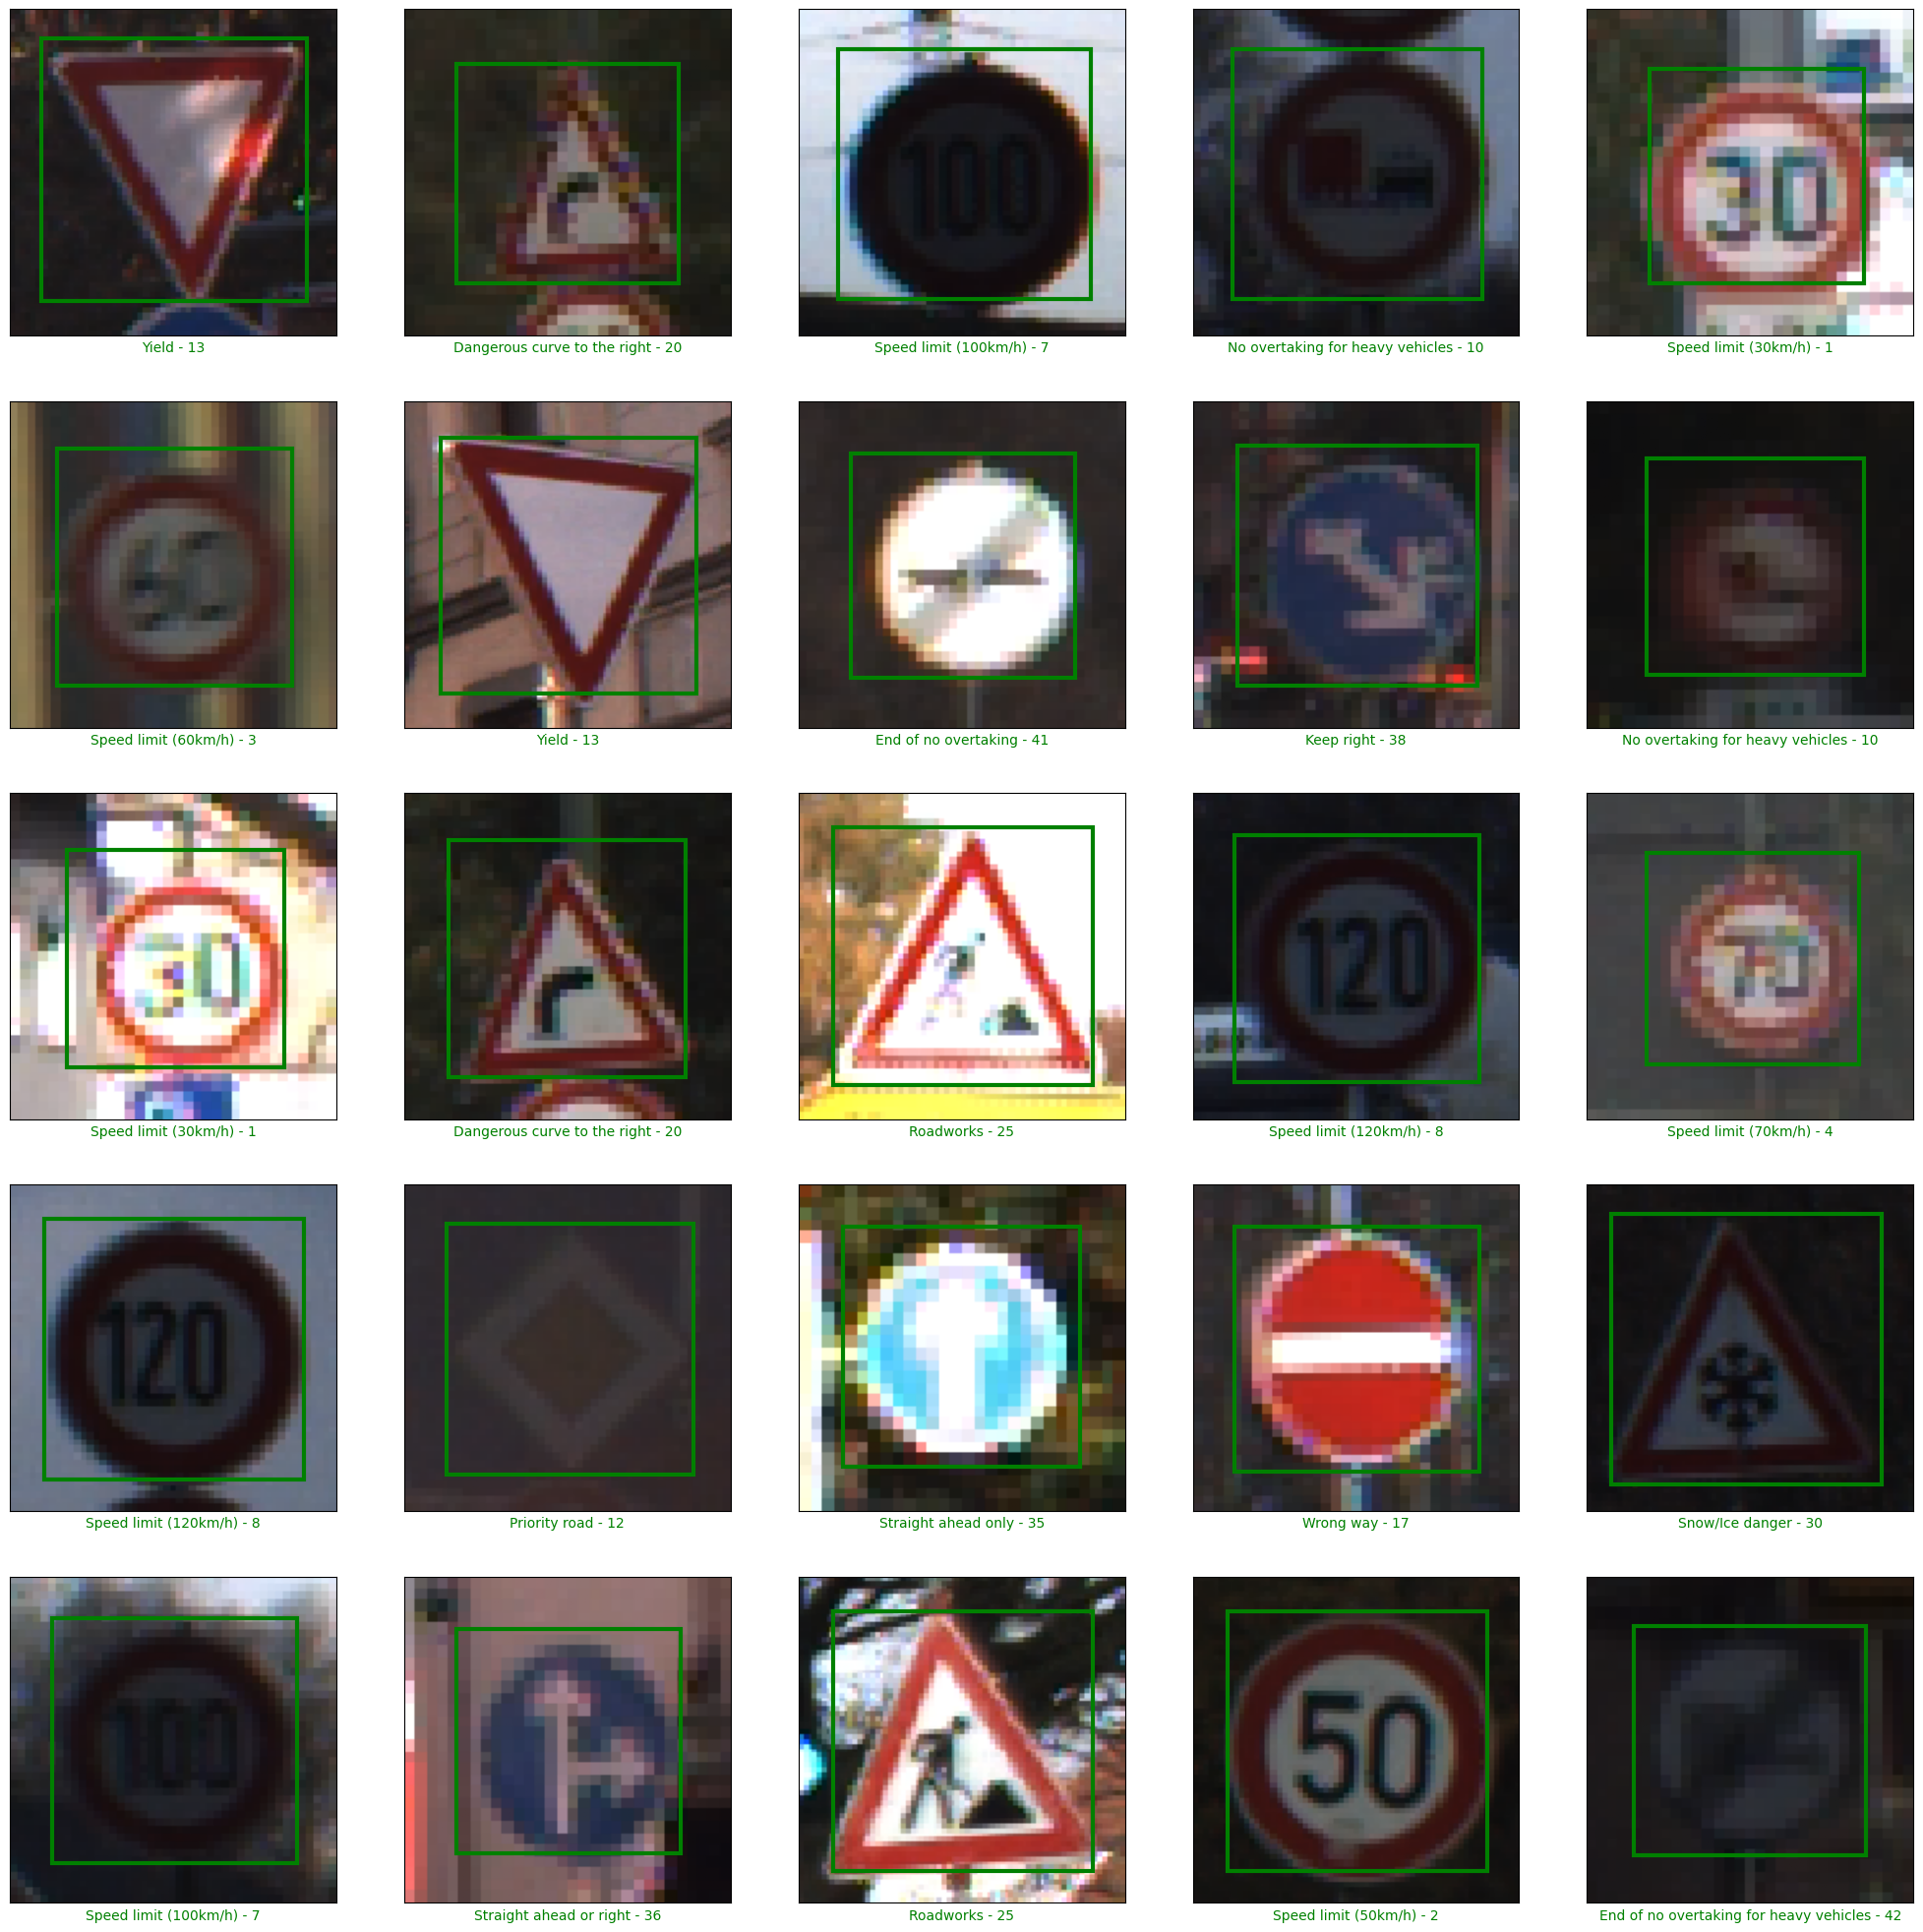

In [ ]:
#Function for plotting bboxes
def patchBBox(bbox, color, h, w):
   # scale the predicted bounding box coordinates based on the image
    # dimensions
    (startX, startY, endX, endY) = bbox
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # Create a Rectangle patch
    rect = Rectangle((startX,startY),endX-startX,endY-startY,linewidth=3,edgecolor=color,facecolor='none')

    return rect

plt.figure(figsize = (25, 25))

for i, ID in enumerate(random.sample(range(len(testLabels)), 25)):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = predLabels[ID]
    actual = testLabels[ID]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('{} - {}'.format(classes.get(int(prediction)), prediction), color = col)
    plt.imshow(X_test[ID])
    (h, w) = X_test[ID].shape[:2]

    # Get the current reference
    ax = plt.gca()

    # Add the patch to the Axes
    ax.add_patch(patchBBox(predBBoxes[ID], col,h, w))
plt.ion()

# save the plot
plotPath = os.path.sep.join([BASE_OUT, "random.png"])
plt.savefig(plotPath)

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images

# Define the function to preprocess the frame for prediction
def preprocess_frame(frame, target_size):
    frame_resized = cv2.resize(frame, target_size)
    frame_array = np.expand_dims(frame_resized, axis=0)
    return frame_array / 255.0  # Normalize the image

# Define the function to draw bounding boxes and labels on the frame
def draw_bounding_box(frame, bbox, label, color=(0, 255, 0)):
    startX, startY, endX, endY = bbox
    cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


# Open the video file
cap = cv2.VideoCapture('/content/WIN_20240620_17_54_12_Pro.mp4')  # Replace with the path to your video

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video writer initialized to save the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
out = cv2.VideoWriter('/content/output_video.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS),
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# Assuming `model` is already defined somewhere in your code
# Load your pre-trained model
#model = load_model('path_to_your_model.h5')  # Replace with the actual path to your model

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame for prediction
    input_frame = preprocess_frame(frame, (128, 128))  # Use the target size expected by your model

    # Make predictions
    with tf.device('/GPU:0'):
        (bbox_preds, class_preds) = model.predict(input_frame)

    # Process predictions (assuming one object per frame)
    for bbox, class_id in zip(bbox_preds, class_preds):
        startX, startY, endX, endY = (bbox * [frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]]).astype(int)
        label = 'Class: {}'.format(classes[np.argmax(class_id)])  # Modify as per your class label logic

        # Draw bounding box and label on the frame
        draw_bounding_box(frame, (startX, startY, endX, endY), label)

    # Write the frame into the output video file
    out.write(frame)

    # Press 'q' on the keyboard to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the video capture and video write objects
cap.release()
out.release()


1/1 [==============================] - 0s 18ms/step


In [ ]:
def process_image(image_path,target_size):
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,target_size)
    image=image/255.0
    image=np.expand_dims(image,axis=0)
    return image

img=process_image('/content/images.jfif',(128,128))

In [ ]:
from google.colab.patches import cv2_imshow

with tf.device('/GPU:0'):
  (predBBoxes, class_id) = model.predict(img)


image_path=r'/content/images.jfif'
image=cv2.imread(image_path)

def draw_bounding_box(frame, bbox, label, color=(0, 255, 0)):
    startX, startY, endX, endY = bbox
    cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


coordinates = (predBBoxes * [image.shape[1], image.shape[0], image.shape[1], image.shape[0]]).astype(int)
label = 'Class: {}'.format(classes[np.argmax(class_id)])  # Modify as per your class label logic

coordinates=tuple(coordinates[0])
        # Draw bounding box and label on the frame
draw_bounding_box(image, coordinates, label)
print(label)
cv2_imshow(image)
cv2.waitKey(0)